In [12]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from transformers import pipeline

In [13]:
import pandas as pd

# df = pd.read_csv('combined_English_scrap_result.csv')
df = pd.read_csv('final_data.csv')
df.head()

,nama,bintang,komentar,Waktu,Place name,clean_text,final_text,review_id
0,Satria Sihombing,5.0,the view is on 🤩🔥🔥,an hour,Bobocabin Baturraden Purwokerto,view nya menyala 🤩🔥🔥,the view i on,0
1,silas nainggolan,5.0,accommodation that is most united with nature....,an hour,Bobocabin Baturraden Purwokerto,penginapan yang paling menyatu dengan alam. ca...,accommodation that i most united with nature t...,1
2,Ari Setiawan,5.0,"nice, new hotel with a high-tech feel, with ve...",2 hours,Bobocabin Baturraden Purwokerto,"bagus, hotel bernuasna baru yang berteknologi ...",nice new hotel with a hightech feel with very ...,2
3,mutiara saragih,5.0,good,2 hours,Bobocabin Baturraden Purwokerto,good,good,3
4,hendro sebayang,5.0,sok an exciting stay experience,2 hours,Bobocabin Baturraden Purwokerto,sok an exciting stay experience,sok an exciting stay experience,4


In [20]:
df[df.review_id == 5649]

,nama,bintang,komentar,Waktu,Place name,clean_text,final_text,review_id
5626,Tiara,5.0,I've been to Jakarta many times and stayed her...,4 months,Bobopod Pancoran Jakarta,berkali2 ke jakarta nginepnya di sini kalau la...,ive been to jakarta many time and stayed here ...,5649


In [14]:
df.dropna(inplace=True)
df.isna().sum()

nama          0
bintang       0
komentar      0
Waktu         0
Place name    0
clean_text    0
final_text    0
review_id     0
dtype: int64

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6751 entries, 0 to 6751
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   nama        6751 non-null   object 
 1   bintang     6751 non-null   float64
 2   komentar    6751 non-null   object 
 3   Waktu       6751 non-null   object 
 4   Place name  6751 non-null   object 
 5   clean_text  6751 non-null   object 
 6   final_text  6751 non-null   object 
 7   review_id   6751 non-null   int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 474.7+ KB


In [15]:
import pandas as pd
import spacy
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

# Load ABSA model
absa_tokenizer = AutoTokenizer.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")
absa_model = AutoModelForSequenceClassification.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")

# Load traditional Sentiment Analysis model
sentiment_model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_model = pipeline("sentiment-analysis", model=sentiment_model_path, tokenizer=sentiment_model_path)

# Function to extract aspects using dependency parsing
def extract_aspects(review):
    doc = nlp(review)
    aspects = set()
    for token in doc:
        if token.dep_ == "nsubj" and token.pos_ == "NOUN":
            aspects.add(token.text.lower())
        elif token.dep_ == "amod" and token.head.pos_ == "NOUN":
            aspects.add(token.head.text.lower())
    return list(aspects)

# Function to perform ABSA
def analyze_aspect_sentiment(sentence, aspect):
    inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
    outputs = absa_model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)
    probs = probs.detach().numpy()[0]
    return {label: prob for label, prob in zip(["negative", "neutral", "positive"], probs)}

# Truncate long sentences to avoid exceeding the maximum token length
def truncate_sentence(sentence, max_length=512):
    tokens = sentence.split()
    if len(tokens) > max_length:
        return ' '.join(tokens[:max_length])
    return sentence

# Process the DataFrame
def process_reviews(df, id_column, text_column):
    results = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing reviews"):
        review_id = row[id_column]
        sentence = row[text_column]
        truncated_sentence = truncate_sentence(sentence)
        aspects = extract_aspects(truncated_sentence)
        for aspect in aspects:
            sentiment_scores = analyze_aspect_sentiment(truncated_sentence, aspect)
            highest_sentiment_label = max(sentiment_scores, key=sentiment_scores.get)
            highest_sentiment_score = sentiment_scores[highest_sentiment_label]
            results.append({
                'review_id': review_id,
                'aspect': aspect,
                'sentiment_label': highest_sentiment_label,
                'sentiment_score': highest_sentiment_score
            })
    return pd.DataFrame(results)

df_ = df.copy()

# Process the DataFrame
processed_df = process_reviews(df_, 'review_id', 'final_text')

# Display the processed DataFrame
print(processed_df.head())

# Save the processed DataFrame to CSV for further analysis
processed_df.to_csv('aspect_sentiment_analysis.csv', index=False)


C:\Users\Muhammad Harun A\AppData\Roaming\Python\Python39\site-packages\transformers\convert_slow_tokenizer.py:562: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Processing reviews:   9%|▉         | 612/6751 [18:57<3:10:06,  1.86s/it] 


KeyboardInterrupt: 

In [ ]:
df.iloc[369]

C:\Users\Muhammad Harun A\AppData\Roaming\Python\Python39\site-packages\transformers\convert_slow_tokenizer.py:562: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


                                              review   aspect sentiment_label  \
0                                 the view is on 🤩🔥🔥     View        negative   
1                                 the view is on 🤩🔥🔥     View         neutral   
2                                 the view is on 🤩🔥🔥     View        positive   
3  nice, new hotel with a high-tech feel, with ve...  Service        negative   
4  nice, new hotel with a high-tech feel, with ve...  Service         neutral   

   sentiment_score  
0         0.010251  
1         0.911546  
2         0.078204  
3         0.000552  
4         0.001676  


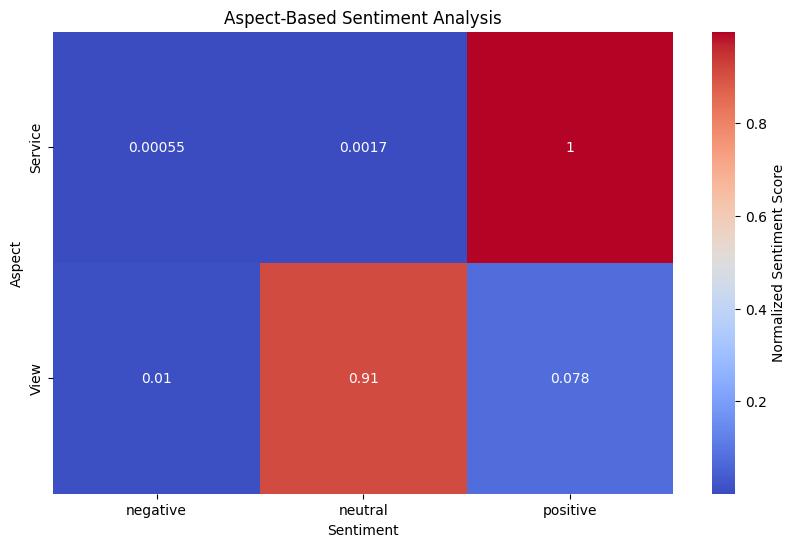

In [31]:
import pandas as pd
import spacy
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

# Load ABSA model
absa_tokenizer = AutoTokenizer.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")
absa_model = AutoModelForSequenceClassification.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")

# Load traditional Sentiment Analysis model
sentiment_model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_model = pipeline("sentiment-analysis", model=sentiment_model_path, tokenizer=sentiment_model_path)

# Predefined aspects
ASPECTS = ['Room', 'Location', 'Service', 'Cleanliness', 'Price']

# Truncate long sentences to avoid exceeding the maximum token length
def truncate_sentence(sentence, max_length=512):
    tokens = sentence.split()
    if len(tokens) > max_length:
        return ' '.join(tokens[:max_length])
    return sentence

# Function to perform ABSA
def analyze_aspect_sentiment(sentence, aspect):
    inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
    outputs = absa_model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)
    probs = probs.detach().numpy()[0]
    return {label: prob for label, prob in zip(["negative", "neutral", "positive"], probs)}

# Check if aspect is present in the sentence
def is_aspect_present(sentence, aspect):
    doc = nlp(sentence)
    return any(token.text.lower() == aspect.lower() for token in doc)

# Process the DataFrame
def process_reviews(df, text_column):
    results = []
    for index, row in df.iterrows():
        sentence = row[text_column]
        truncated_sentence = truncate_sentence(sentence)
        for aspect in ASPECTS:
            if is_aspect_present(sentence, aspect):
                sentiment_scores = analyze_aspect_sentiment(truncated_sentence, aspect)
                for label, score in sentiment_scores.items():
                    results.append({
                        'review': sentence,
                        'aspect': aspect,
                        'sentiment_label': label,
                        'sentiment_score': score
                    })
    return pd.DataFrame(results)

df_ = df.iloc[:5]

# Process the DataFrame
processed_df = process_reviews(df_, 'komentar')

# Display the processed DataFrame
print(processed_df.head())

# Save the processed DataFrame to CSV for further analysis
processed_df.to_csv('aspect_sentiment_analysis.csv', index=False)

# Visualization
def visualize_aspect_sentiment(df):
    # Pivot the data for visualization
    pivot_df = df.pivot_table(values='sentiment_score', index='aspect', columns='sentiment_label', aggfunc='mean').fillna(0)

    # Normalize the scores to avoid bias
    pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_df, annot=True, cmap='coolwarm', cbar_kws={'label': 'Normalized Sentiment Score'})
    plt.title('Aspect-Based Sentiment Analysis')
    plt.xlabel('Sentiment')
    plt.ylabel('Aspect')
    plt.show()

# Visualize the processed DataFrame
visualize_aspect_sentiment(processed_df)


In [35]:
sentence = "rooms, good facilities, quiet, away from the crowds, very beautiful waterfall, don't forget breakfast, really delicious, warlok damar dinner, recommended is delicious, everyone must try ordering directly, staff orders food"
# sentence = translated
print(f"Sentence: {sentence}")
print()

# ABSA of "food"
aspect = "Room"
inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
outputs = absa_model(**inputs)
probs = F.softmax(outputs.logits, dim=1)
probs = probs.detach().numpy()[0]
print(f"Sentiment of aspect '{aspect}' is:")
for prob, label in zip(probs, ["negative", "neutral", "positive"]):
  print(f"Label {label}: {prob}")
print()

# ABSA of "Location"
aspect = "Location"
inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
outputs = absa_model(**inputs)
probs = F.softmax(outputs.logits, dim=1)
probs = probs.detach().numpy()[0]
print(f"Sentiment of aspect '{aspect}' is:")
for prob, label in zip(probs, ["negative", "neutral", "positive"]):
  print(f"Label {label}: {prob}")
print()

# ABSA of "service"
aspect = "Service"
inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
outputs = absa_model(**inputs)
probs = F.softmax(outputs.logits, dim=1)
probs = probs.detach().numpy()[0]
print(f"Sentiment of aspect '{aspect}' is:")
for prob, label in zip(probs, ["negative", "neutral", "positive"]):
  print(f"Label {label}: {prob}")
print()

# ABSA of "Cleanliness"
aspect = "Cleanliness"
inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
outputs = absa_model(**inputs)
probs = F.softmax(outputs.logits, dim=1)
probs = probs.detach().numpy()[0]
print(f"Sentiment of aspect '{aspect}' is:")
for prob, label in zip(probs, ["negative", "neutral", "positive"]):
  print(f"Label {label}: {prob}")
print()

# ABSA of "Price"
aspect = "Price"
inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
outputs = absa_model(**inputs)
probs = F.softmax(outputs.logits, dim=1)
probs = probs.detach().numpy()[0]
print(f"Sentiment of aspect '{aspect}' is:")
for prob, label in zip(probs, ["negative", "neutral", "positive"]):
  print(f"Label {label}: {prob}")
print()

# ABSA of "Food"
aspect = "food"
inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
outputs = absa_model(**inputs)
probs = F.softmax(outputs.logits, dim=1)
probs = probs.detach().numpy()[0]
print(f"Sentiment of aspect '{aspect}' is:")
for prob, label in zip(probs, ["negative", "neutral", "positive"]):
  print(f"Label {label}: {prob}")
print()

# Overall sentiment of the sentence
sentiment = sentiment_model([sentence])[0]
print(f"Overall sentiment: {sentiment['label']} with score {sentiment['score']}")
# Overall sentiment: Negative with score 0.7706006765365601

Sentence: Can't choose a room, there is no water refill in best cabins no. 11 and 34

Sentiment of aspect 'Room' is:
Label negative: 0.05030994117259979
Label neutral: 0.947429358959198
Label positive: 0.00226070755161345

Sentiment of aspect 'Location' is:
Label negative: 0.5756540894508362
Label neutral: 0.397415429353714
Label positive: 0.026930460706353188

Sentiment of aspect 'Service' is:
Label negative: 0.8695281744003296
Label neutral: 0.09458485245704651
Label positive: 0.03588702529668808

Sentiment of aspect 'Cleanliness' is:
Label negative: 0.9051947593688965
Label neutral: 0.03938903287053108
Label positive: 0.05541619658470154

Sentiment of aspect 'Price' is:
Label negative: 0.5805014371871948
Label neutral: 0.37701931595802307
Label positive: 0.0424792654812336

Sentiment of aspect 'food' is:
Label negative: 0.924163281917572
Label neutral: 0.06482042372226715
Label positive: 0.011016339994966984

Overall sentiment: negative with score 0.6162237524986267
